In [150]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

# Get Gauss-Fit Features

### Use a small subgroup from the dataset to create feature extraction code
##### The profiles chosen must:
##### - Be typical residential users
##### - Have enough data collected for winter/weekdays
##### - Have a gauss fit with a low error

In [2]:
X = genX([1994,2014],drop_0 = True)

dropping all zero rows


In [3]:
# Collect only winter weekday profiles from dataset

X.reset_index(inplace = True)

df = X.copy()

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_14620/2621424369.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_14620/2621424369.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

### Get households that pass the stictily residential test

In [4]:
mean = df_winter_weekdays.groupby(["ProfileID"]).mean()

# Test 1: Energy between 9-5 
i = np.arange(9,17)
sum_df = pd.DataFrame(index = mean.index, columns = ["9_to_5", 'total'])
sum_df = sum_df.fillna(0)
for x in i:
    temp = mean.iloc[:,x]
    sum_df['9_to_5'] = sum_df['9_to_5'] + temp

sum_df['total'] =  mean.sum(axis = 1)

sum_df["percentage"] = (sum_df["9_to_5"]/sum_df["total"]) * 100

def check_9_to_5(df):
    if df > 50:
        return 'B'
    else: 
        return 'R'

sum_df['Labels'] = sum_df['percentage'].apply(check_9_to_5)

# 173 households labeled as Businesses for the 9-to-5 check
sum_df[sum_df['percentage'] > 50]

,9_to_5,total,percentage,Labels
ProfileID,,,,
66,7.314488,14.168734,51.624145,B
217,29.234047,48.776469,59.934734,B
221,11.493651,22.538165,50.996394,B
232,46.414889,88.394214,52.508967,B
284,22.920155,44.093986,51.980230,B
...,...,...,...,...
12028369,19.029901,37.612317,50.594864,B
12028403,6.608640,8.126843,81.318658,B
12028447,24.028575,45.127989,53.245392,B


In [5]:
# Tests 2: ToP
top_df = pd.DataFrame()

top_df['Time'] = mean.idxmax(axis=1)

def check_top(df):
    if int(df) > 9 and int(df) < 17:
        return 'B'
    else:
        return 'R'  

top_df['Labels'] = top_df['Time'].apply(check_top)

### Extract households that are residential according to test

In [6]:
new_df = pd.DataFrame()

new_df['ToP'], new_df['Sum'] = top_df['Labels'], sum_df['Labels']

data_classes = ['R','B']
d = dict(zip(data_classes, range(0,2)))

new_df['ToP'],new_df['Sum'] = new_df['ToP'].map(d, na_action='ignore'),new_df['Sum'].map(d, na_action='ignore')

new_df['Total'] = new_df.sum(axis = 1)

In [7]:
residential_ids = new_df[new_df['Total'] == 0].index.values # Contains the profile ids that have typical residential behaviour

# Extract Residential households that have complete data
### Housholds must have:
### - Atleast 3 months of winter weekday data, i.e. +-60 days of data

In [8]:
df_winter_weekdays.reset_index(inplace = True)

In [9]:
# Remove all households with less than three winter months
winter_months_ids = []

for i in df_winter_weekdays['ProfileID'].unique():
    if len(df_winter_weekdays[df_winter_weekdays['ProfileID'] == i]) >= 30:

        winter_months_ids.append(i) # Contains the profile Ids that have a complete winter months data

winter_months_ids = np.asarray(winter_months_ids)

In [10]:
profileIDs = np.intersect1d(winter_months_ids, residential_ids)

# Filter out all the ids from the above two extractions steps

In [11]:
cleaned_df = df_winter_weekdays[df_winter_weekdays['ProfileID'].isin(profileIDs)]
cleaned_df.head()

,ProfileID,date,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,1,1994-06-20,1.058333,1.625000,0.341667,2.100000,1.225000,1.058333,4.808333,4.091667,...,1.433333,2.641667,2.116667,5.541667,5.275000,6.533333,4.708333,10.433333,9.508333,4.408333
1,1,1994-06-21,0.425000,2.350000,0.550000,0.291667,2.100000,0.591667,4.066667,2.791667,...,3.150000,1.825000,4.016667,1.833333,3.466667,8.875000,10.850000,12.908333,9.241667,2.625000
2,1,1994-06-22,0.741667,2.325000,0.583333,1.191667,1.225000,0.575000,4.066667,3.350000,...,1.500000,0.933333,2.791667,6.291667,6.491667,4.458333,13.125000,10.750000,6.200000,1.350000
3,1,1994-06-23,1.166667,1.883333,0.450000,0.541667,2.333333,0.341667,4.216667,2.341667,...,2.666667,4.758333,2.391667,5.233333,3.250000,5.958333,10.466667,10.066667,5.016667,0.733333
4,1,1994-06-24,2.408333,0.591667,0.316667,2.341667,0.550000,1.183333,3.783333,2.958333,...,5.400000,1.041667,4.083333,3.191667,2.216667,4.258333,2.725000,0.975000,1.216667,1.608333


# Extract gauss_fit features
### Extract the mean amplitudes
### Sigma values
### Mean amplitude deviation
### Mean Daily consumptions
### Deviation in daily consumption
### Time of peaks


In [12]:
reduced_list = random.choices(profileIDs,k = 20)

In [13]:
# Create Dataframe
cols = ['ProfileID','H_offset','sigma1','sigma2','mu1','A1','sigma3','sigma4','mu2','A2']

# cols = pd.MultiIndex.from_tuples([("ProfileID",''),
#                                 ('H_offset', 'H_offset'),
#                                  ("Morning", "sigma1"), 
#                                   ("Morning", "sigma2"), 
#                                   ("Morning", "mu1"),
#                                   ("Morning", "A1"),
#                                   ("Afternoon", "sigma3"), 
#                                   ("Afternoon", "sigma4"), 
#                                   ("Afternoon", "mu2"),
#                                   ("Afternoon", "A2")])

# Create dummy variables
H_offset = 0
sigma1 = 0
sigma2 = 0 
mu1 = 0
A1 = 0 
sigma3 = 0 
sigma4 = 0 
mu2 = 0
A2 = 0

data=[['DROP_ROW',H_offset,sigma1,sigma2, mu1, A1, sigma3, sigma4, mu2,A2]]

gauss_df = pd.DataFrame(data, columns=cols)

# reduced_list = [1005615]
for id in tqdm(reduced_list):
    H_offset,sigma1, sigma2, mu1, A1, sigma3, sigma4, mu2, A2, check = extractFIT(cleaned_df,id)
    print(check)
    if check == False:
        continue

    data=[[id,H_offset,sigma1,sigma2, mu1, A1, sigma3, sigma4, mu2,A2]]
    temp_df = pd.DataFrame(data, columns=cols)
    temp_df.set_index(['ProfileID'])
    gauss_df = gauss_df.append(temp_df)

gauss_df = gauss_df.set_index(['ProfileID'])

# Store Gaussian Fit features
temp = gauss_df.copy()
temp.drop(['DROP_ROW'],axis = 0, inplace = True)
# # # temp.to_csv('FitFeatures_1200_2500.csv')

C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_14620/3266001112.py:31: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/20 [00:00<?, ?it/s]

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Extract the amplitude of every day for each profile

In [14]:
# reduced_list = random.choices(profileIDs,k = 10)

In [15]:
t = cleaned_df[cleaned_df['ProfileID'] == 5]
t_series = t.iloc[0]
t_series.drop(labels = ['date'], inplace = True)
t_frame = t_series.to_frame()
t_frame = t_frame.T
t_frame.reset_index(inplace = True)
t_frame.drop(['index'], axis = 1, inplace = True)
t_frame.set_index(['ProfileID'], inplace = True)
t_frame
# df = df.drop(labels = ['ProfileID', 'date'])

C:\Users\MEDIA_LAB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:4150: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ProfileID,,,,,,,,,,,,,,,,,,,,,
5,2.97775,1.069333,1.363583,2.370667,1.098,2.6325,7.26575,8.111167,11.583917,9.582167,...,9.444333,17.527,13.849,11.341917,9.104583,15.9335,17.159333,6.229917,4.240667,4.9265


In [16]:
# Create cols
cols = ['ProfileID','A1','A2','mu1','mu2']

# Create dummy variables
mu1 = 0
A1 = 0 
mu2 = 0
A2 = 0

data=[['DROP_ROW',A1,A2,mu1,mu2]]

amplitudes_df = pd.DataFrame(data, columns=cols)

for id in reduced_list:
    for index in cleaned_df[cleaned_df['ProfileID'] == id].index:
        A1, A2, mu1, mu2, check = extractToPs(cleaned_df[cleaned_df['ProfileID'] == id].loc[index])
        if check == False:
            continue
        
        data=[[id,A1,A2,mu1,mu2]]
        temp_df = pd.DataFrame(data, columns=cols)
        # temp_df.set_index(['ProfileID'])
        amplitudes_df = amplitudes_df.append(temp_df)
    
amplitudes_df = amplitudes_df.set_index(['ProfileID'])
temporary = amplitudes_df.copy()
temporary.drop(['DROP_ROW'],axis = 0, inplace = True)
    

In [17]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
7218,44.102500,57.280416,9,19
7218,49.898916,41.254500,8,18
7218,47.220917,34.228250,9,14
7218,49.412750,42.011333,9,19
7218,56.471250,52.778083,8,20
...,...,...,...,...
1002644,1.623500,4.188833,6,16
1002644,1.604083,4.252333,7,17
1002644,2.895333,3.591917,6,17


# Calculate the amplitude deviations

In [18]:
def standard_deviation(my_list):
    #calculate population standard deviation of list 
    return (sum((x-(sum(my_list) / len(my_list)))**2 for x in my_list) / len(my_list))**0.5

In [19]:
daily_consumption = pd.DataFrame()

daily_consumption['Daily_Consumption'] = cleaned_df.set_index(["ProfileID"]).sum(axis = 1)

std_deviation_df = pd.DataFrame(index = temporary.index.unique())

for id in temporary.index.unique():
    std_deviation_df.loc[id,'A1_std'] = standard_deviation(temporary.loc[id]['A1'])
    std_deviation_df.loc[id,'A2_std'] = standard_deviation(temporary.loc[id]['A2'])
    std_deviation_df.loc[id,'mu1_std'] = standard_deviation(temporary.loc[id]['mu1'])
    std_deviation_df.loc[id,'mu2_std'] = standard_deviation(temporary.loc[id]['mu2'])
    std_deviation_df.loc[id,'DC_std'] = standard_deviation(daily_consumption.loc[id]['Daily_Consumption'])


C:\Users\MEDIA_~1\AppData\Local\Temp/ipykernel_14620/921994390.py:3: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [20]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
7218,44.102500,57.280416,9,19
7218,49.898916,41.254500,8,18
7218,47.220917,34.228250,9,14
7218,49.412750,42.011333,9,19
7218,56.471250,52.778083,8,20
...,...,...,...,...
1002644,1.623500,4.188833,6,16
1002644,1.604083,4.252333,7,17
1002644,2.895333,3.591917,6,17


In [21]:
std_deviation_df

,A1_std,A2_std,mu1_std,mu2_std,DC_std
ProfileID,,,,,
7218,8.388276,10.080164,0.722642,1.559263,129.470741
3469,0.396962,0.335729,2.312055,1.984843,4.189289
1005384,0.494558,0.346268,1.143647,1.781164,1.366361
3712,0.957093,0.499017,1.386711,1.328935,3.284923
1001768,2.923135,2.858861,1.536582,2.627975,19.967291
8412,0.511905,0.550320,2.664124,1.248918,3.674807
1005203,1.752437,2.136824,1.749921,1.951851,12.117984
1225,2.595739,4.479231,1.157877,1.981318,28.200823
7180,1.446136,3.014062,0.895706,1.764784,13.005796


# Combine the features extracted for the synthetic profiles

In [22]:
# std_deviation_df
# temp.columns = temp.columns.droplevel(0)
temp
combined_df = pd.merge(temp,std_deviation_df, left_index = True, right_index = True)

In [23]:
len(combined_df)

20

# Check the distribution of the amplitude and Time

In [24]:
import re
import pandas as pd
import numpy as np
# from mlutils import dataset, connector
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [26]:
def standarise(df,column,pct,pct_lower):    
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [252]:
def fit_distribution(df,column,pct,pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std,size,y_org = standarise(df,column,pct,pct_lower)
    print(df)
    print(y_std)
    dist_names = ['weibull_min','norm','weibull_max','beta',
                    'invgauss','uniform','gamma','expon', 
                    'pearson3','alpha',
                    'arcsine','cauchy','dweibull',
                    'halflogistic','logistic',
                    'powerlaw','powernorm']#'triang','loggamma','lognorm','exponnorm',
    y_std = y_org

    chi_square_statistics = []
    parameters = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        print(dist)
        param = dist.fit(y_std)
        # print("{}\n{}\n".format(dist, param))
        parameters.append(param)

        # Get expected counts in percentile bins
        # cdf of fitted distrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results['params'] = parameters
    results.sort_values(['chi_square'], inplace=True)


    # print ('\nDistributions listed by Betterment of fit:')
    # print ('............................................')
    # print (results)
    return results.iloc[0]

### Check which distribution describes the data best

In [253]:
profiles_ids = temporary.index.unique().values

cols = pd.MultiIndex.from_tuples([#("ProfileID",''),
                                ('A1', 'Distribution'),
                                 ("A1", "chi_square"), 
                                  ("A1", "params"), 
                                  ("A2", "Distribution"),
                                  ("A2", "chi_square"),
                                  ("A2", "params") 
                                  #, ('t1', 'Distribution'),
                                  # ("t1", "chi_square"), 
                                  # ("t1", "params"), 
                                  # ("t2", "Distribution"),
                                  # ("t2", "chi_square"),
                                  # ("t2", "params"),
                                ])
distributions_df = pd.DataFrame(index = profiles_ids,columns = cols)
results = []
for id in profiles_ids:
    # Extract the best distribution fitted
    results1 = fit_distribution(temporary.loc[id],'A1',0.99,0.01)
    results2 = fit_distribution(temporary.loc[id],'A2',0.99,0.01)
    # results3 = fit_distribution(temporary.loc[id],'mu1',0.99,0.01)
    # results4 = fit_distribution(temporary.loc[id],'mu2',0.99,0.01)

    results = [results1.values[0],results1.values[1],results1.values[2], results2.values[0],results2.values[1],results2.values[2]]
              # ,results3.values[0],results3.values[1],results3.values[2], results4.values[0],results4.values[1],results4.values[2]]

    distributions_df.loc[id] = results


                  A1         A2  mu1  mu2
ProfileID                                
7218       44.102500  57.280416    9   19
7218       49.898916  41.254500    8   18
7218       47.220917  34.228250    9   14
7218       49.412750  42.011333    9   19
7218       56.471250  52.778083    8   20
7218       45.543084  56.388584    8   19
7218       40.513417  45.531500    8   19
7218       49.070250  59.372750    8   18
7218       35.032250  68.497001    7   18
7218       43.278583  62.606166    9   18
7218       44.277500  60.795667    8   18
7218       50.444583  69.668750    8   18
7218       49.078917  62.892749    9   18
7218       49.027750  53.024334    7   20
7218       50.333500  45.713333    7   13
7218       45.955250  39.753583    7   19
7218       49.279000  50.552416    7   18
7218       44.825750  62.835083    7   19
7218       44.417417  52.968001    7   19
7218       44.892917  48.775417    7   19
7218       47.286167  49.361500    7   18
7218       46.634667  52.225250   

## Plot the theoretical vs actual cumulative distributions

In [254]:
# level_0 = distributions_df.columns.get_level_values(0).unique()
# houseID = 1003093
# for column in level_0:

#     distributions = distributions_df[column].loc[houseID]['Distribution']
#     parameters = distributions_df[column].loc[houseID]['params']

#     if distributions == 'invgauss':
#         print('invgauss')
#         data_points = invgauss.rvs(parameters[0], parameters[1], parameters[2],size = 2000)
#     elif distributions == 'weibull_min':
#         print('weibull_min')
#         data_points = weibull_min.rvs(parameters[0], parameters[1], parameters[2], size = 2000)
#     elif distributions == 'weibull_max':
#         print('weibull_max')
#         data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 2000)
#     elif distributions == 'beta':
#         print('beta')
#         data_points == beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 2000)
#     elif distributions == 'norm':
#         print('norm')
#         data_points = norm.rvs(parameters[0], parameters[1], 2000)

#     y_std,len_y,y = standarise(temporary.loc[houseID],column,0.99,0.01)
    
#     y_std = y

#     f, ax = plt.subplots(figsize=(8,8))
#     ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

#     percentile_bins = np.linspace(0,100,51)
#     percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

#     percentile_cutoffs = np.percentile(data_points, percentile_bins)

#     ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',label = distributions + ' Distribution',s = 40)
#     ax.set_title('Cumulative Distribution ' + column + ' theo vs obs.') 
#     ax.set_xlabel('Theoretical cumulative distribution')
#     ax.set_ylabel('Observed cumulative distribution')
#     ax.legend()
#     plt.show()

# Create synthetic profile for a single user

### Function to reverse the standardisation process used when fitting distribution to data

In [255]:
def inverse_StandardScalar(data_points,df,column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std = sc.transform(yy)
    y_std = y_std.flatten()

    inversed_data_points = sc.inverse_transform(data_points)

    return inversed_data_points

In [256]:
# distributions = distributions_df['A1'].loc[houseID]['Distribution']
# parameters = distributions_df['A1'].loc[houseID]['params']
# data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
# inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],'A1',0.99,0.01)

### Verify that inverse_StandardScalar works

In [257]:
# inv_data_df = pd.DataFrame(inverse_data_points)
# temp_df = pd.DataFrame(temporary['A1'].values)
# inv_data_df.columns = ['A1']
# temp_df.columns = ['A1']
# inv_data_df['label'] = 'synth'
# temp_df['label'] = 'observed'
# synth_obs_df = temp_df.append(inv_data_df, ignore_index = True)
# sns.displot(data = synth_obs_df, x= 'A1',  stat="density", hue = 'label').set(title = 'Distribution Plot: A1 Obs. vs. Theo')

### Construct the Synthetic profile generator

In [258]:
# Define function that approximates straight line
def straight_line(m,x,b):
    return m*x+b

### Loop that generates n synthetic amplitude values

In [269]:
level_0 = distributions_df.columns.get_level_values(0).unique()
inv_data_df = pd.DataFrame()
temp_df_inv = pd.DataFrame()
for houseID in distributions_df.index:
    for column in level_0:

        distributions = distributions_df[column].loc[houseID]['Distribution']
        parameters = distributions_df[column].loc[houseID]['params']

        # loc = combined_df.loc[houseID][column]
        # scale = combined_df.loc[houseID][column + '_std']  
        loc = parameters[-2]
        scale = parameters[-1]
        size = len(cleaned_df[cleaned_df['ProfileID'] == houseID])

        if distributions == 'invgauss':
            print('invgauss')
            data_points = invgauss.rvs(parameters[0],loc = loc,scale = scale,size = size)
        elif distributions == 'weibull_min':
            print('weibull_min')
            data_points = weibull_min.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'weibull_max':
            print('weibull_max')
            print(f'loc = {loc}, scale = {scale}')
            data_points = weibull_max.rvs(parameters[0], loc = loc, scale = scale, size = size)
            # data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
        elif distributions == 'beta':
            print('beta')
            data_points = beta.rvs(parameters[0], parameters[1], loc = loc,scale = scale, size = size)
            # data_points = beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 60)
        elif distributions == 'norm':
            print('norm')
            data_points = norm.rvs(parameters[0], parameters[1], size = size)
        # elif distributions == 'triang':
        #     print('triang')
        #     data_points = triang.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'pearson3':
            print('pearson3')
            data_points = pearson3.rvs(parameters[0], loc = loc,scale = scale, size = size)
        # elif distributions == 'lognorm':
        #     print('lognorm')
        #     data_points = lognorm.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'uniform':
            print('uniform')
            data_points = uniform.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'expon':
            print('expon')
            data_points = expon.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'gamma':
            print('gamma')
            data_points = gamma.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'alpha':
            print('alpha')
            data_points = alpha.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'arcsine':
            print('arcsine')
            data_points = arcsine.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'cauchy':
            print('cauchy')
            data_points = cauchy.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'dweibull':
            print('dweibull')
            data_points = dweibull.rvs(parameters[0], loc=loc, scale = scale,size=size)
        # elif distributions == 'exponnorm':
        #     print('exponnorm')
        #     data_points = exponnorm.rvs(K=1.5, loc=loc, scale = scale,size=size)
        elif distributions == 'halflogistic':
            print('halflogistic')
            data_points = halflogistic.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'logistic':
            print('logistic')
            data_points = logistic.rvs(loc=loc, scale = scale,size=size)
        # elif distributions == 'loggamma':
        #     print('loggamma')
        #     data_points = loggamma.rvs(parameters[0], loc=loc, scale = scale,size=size)*-1
        elif distributions == 'powerlaw':
            print('powerlaw')
            data_points = powerlaw.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'powernorm':
            print('powernorm')
            data_points = powernorm.rvs(parameters[0], loc=loc, scale = scale,size=size)
        

        # print(column)
        # inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],column,0.99,0.01)
        temp_df_inv['ProfileID'] = houseID
        temp_df_inv[column] = data_points#inverse_data_points
        
    inv_data_df = inv_data_df.append(temp_df_inv)
    temp_df_inv = pd.DataFrame()
        # if column == 'A1':
        #     data_pointA1 = data_points#inverse_data_points
        # elif column == 'A2':
        #     data_pointsA2 = data_points#inverse_data_points

inv_data_df = inv_data_df.dropna()
inv_data_df.set_index(['ProfileID'], inplace = True)

beta
pearson3
weibull_min
pearson3
uniform
weibull_max
loc = 1502250.8767666062, scale = 1502250.469209544
weibull_min
cauchy
pearson3
pearson3
pearson3
dweibull
beta
dweibull
cauchy
dweibull
dweibull
beta
powerlaw
logistic
dweibull
logistic
alpha
weibull_min
pearson3
alpha
powerlaw
weibull_min
pearson3
uniform
weibull_min
uniform
pearson3
alpha
weibull_min
powernorm
pearson3
alpha
pearson3
uniform


# Generate synthetic profiles

### Function that generates synthetic profiles

In [270]:
def generate_synth_profiles2(id,A1,A2,mu1,mu2, H_offset):    
    # Straight line approximation between: mu1 + 4 to mu2 - 4
    # Determine the complete synthetic profile
    
    
    x_1 = np.arange(0,mu1,1)
    x_2 = np.arange(mu1,mu1+3,1)
    x_3 = np.arange(mu2-3,mu2+1,1)
    x_4 = np.arange(mu2,23,1)

    x_vals = np.hstack((x_1,x_2,x_3,x_4))
    x_vals_1 = np.unique(x_vals)
    synthetic_df2 = pd.DataFrame()
    i = 0
    temp = pd.DataFrame()
    for A1_item, A2_item in zip(A1.A1.iteritems(), A2.A2.iteritems()):
        i = i + 1
        gauss1 = gauss(x_1, H_offset ,A1_item[1], mu1, sigma1)
        gauss2 = gauss(x_2, H_offset ,A1_item[1], mu1, sigma2)
        gauss3 = gauss(x_3, H_offset ,A2_item[1], mu2, sigma3)
        gauss4 = gauss(x_4, H_offset ,A2_item[1], mu2, sigma4)


        i2 = mu1 + 3
        i3 = mu2 - 3

        if len(x_vals_1) == 24:
                # print("Entire array is captured")
                if x_2[-1] == x_3[0]:
                    x_3 = x_3[1:] # Remove the first value of the x-array
                    y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
                else:
                    synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

        else:
            # print("Missing hours need to be saved")
            x_5 = np.arange(i2,i3,1)
            x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
            x_vals_1 = np.unique(x_vals_1)

            # Synthesize the mid range behaviour
            m = (gauss(x_3[0], H_offset,A2_item[1],mu2,sigma3) - gauss(x_2[-1], H_offset,A1_item[1],mu1,sigma2))/(x_3[0]-x_2[-1]) # Calculate slope
            b = gauss(x_3[0], H_offset,A2_item[1],mu2,sigma3) - m*x_3[0] # Calculate b constant for straight line equation
            y_mid = straight_line(m,x_5,b)

            synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))
            values = synth.tolist()
            df = pd.DataFrame(values)
            df = df.T

            temp = temp.append(df)

    temp['ProfileID'] = id
    temp.set_index(['ProfileID'], inplace = True)        

    return temp

### Loop that creates the synthetic profiles

In [271]:
synthetic_df = pd.DataFrame()
for id in distributions_df.index.unique():
    houseID = id

    H_offset = combined_df.loc[houseID]['H_offset']

    mu1 = combined_df.loc[houseID]['mu1']
    mu2 = combined_df.loc[houseID]['mu2']

    sigma1 = combined_df.loc[houseID]['sigma1']
    sigma2 = combined_df.loc[houseID]['sigma2']
    sigma3 = combined_df.loc[houseID]['sigma3']
    sigma4 = combined_df.loc[houseID]['sigma4']

    A1 = inv_data_df.loc[houseID]['A1']
    A2 = inv_data_df.loc[houseID]['A2']
    A1 = pd.DataFrame(A1)
    A2 = pd.DataFrame(A2)
    A1 = A1- H_offset
    A2 = A2-H_offset

    A1.reset_index(inplace=True)
    A2.reset_index(inplace=True)


    synth = generate_synth_profiles2(houseID,A1,A2,mu1,mu2,H_offset)
    # temp = pd.DataFrame(synth)
    # temp = temp.T
    synthetic_df = synthetic_df.append(synth)
    synthetic_df

In [272]:
synthetic_df_temp = synthetic_df.reset_index()
synthetic_df_mean = synthetic_df_temp.groupby(['ProfileID']).median()
synthetic_df_mean

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
ProfileID,,,,,,,,,,,,,,,,,,,,,
1225,1.154994,1.155019,1.157904,1.270047,2.745737,8.846670,14.161520,12.179700,7.869036,7.927661,...,8.372679,8.430406,8.584897,11.003040,12.816918,13.492961,13.492961,12.043212,8.638349,5.160545
3469,0.661281,0.719071,0.798881,0.893241,0.985513,1.053772,1.079037,1.060346,1.008433,0.988916,...,0.831249,0.841901,0.819622,1.020798,1.217756,1.301618,1.301618,1.249353,1.114424,0.947884
3712,0.028614,0.028614,0.028614,0.028614,0.029397,0.225927,1.274982,0.872359,0.290376,0.253041,...,0.066366,0.029049,0.063631,0.516102,1.201329,1.201329,1.118257,0.902708,0.633976,0.390570
5052,0.883316,0.883316,0.883316,0.883344,0.898649,1.555308,3.252556,2.649251,1.614576,1.827420,...,2.486556,2.632551,4.084494,5.483623,6.074653,6.074653,5.807599,5.086075,4.110722,3.113293
5377,3.563369,3.563369,3.563369,3.564115,3.706476,6.915473,13.154496,11.328073,7.683308,8.051214,...,11.131314,11.678542,12.237898,12.828944,13.556844,16.078425,17.887310,18.546611,18.546611,15.693377
5404,3.695802,3.695802,3.695802,3.696071,3.727408,4.645500,11.011740,18.144594,16.510090,12.634686,...,3.700474,4.140762,10.543958,20.730110,20.730110,19.909261,17.676510,14.617371,11.425156,8.651488
7180,0.984241,0.984241,0.984242,0.984721,1.020768,1.790340,6.144239,10.565073,6.389187,1.954652,...,1.170573,1.017825,1.587977,4.401433,7.074141,7.074141,6.760863,5.914451,4.770275,3.600202
7218,19.492484,19.492484,19.492484,19.492484,19.492498,19.531242,24.064693,41.916561,38.635388,31.401821,...,21.553041,19.588106,21.652258,33.511574,45.643608,45.643608,43.943455,39.477909,33.772944,28.412847
8412,0.190402,0.192387,0.193056,0.191207,0.185812,0.200509,0.225277,0.261235,0.252573,0.265093,...,0.317727,0.322677,0.333177,0.341454,0.570643,0.789771,0.881975,0.881975,0.785275,0.558166


## Plot the synthetic vs actual profiles

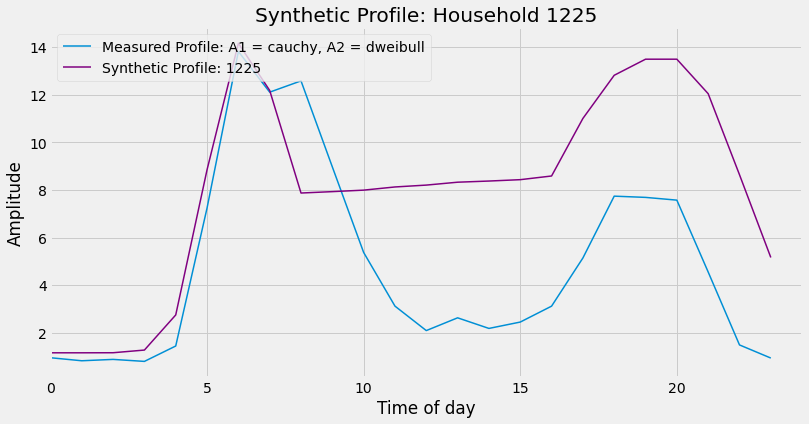

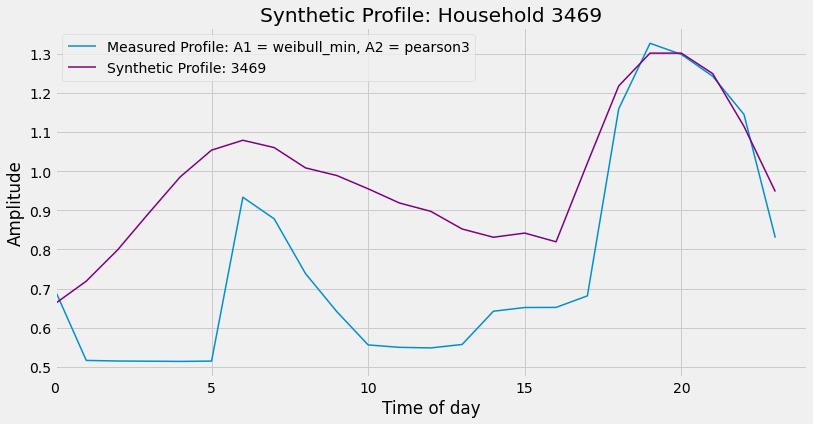

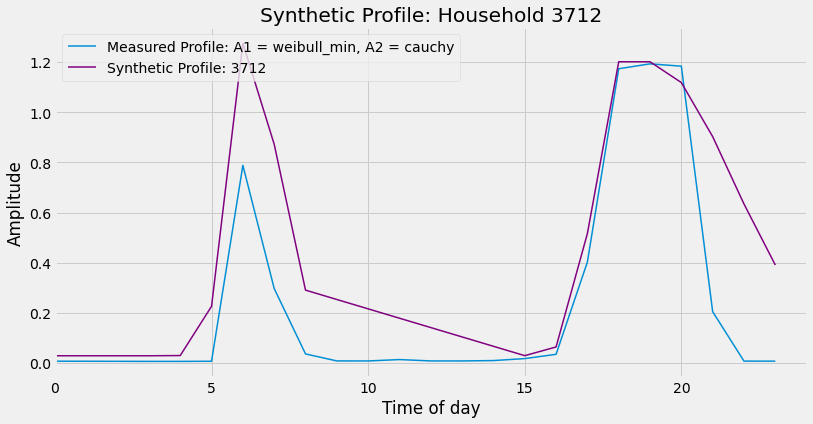

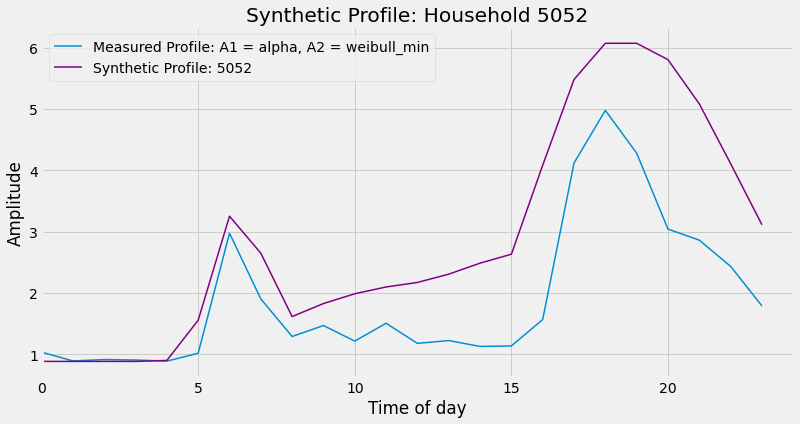

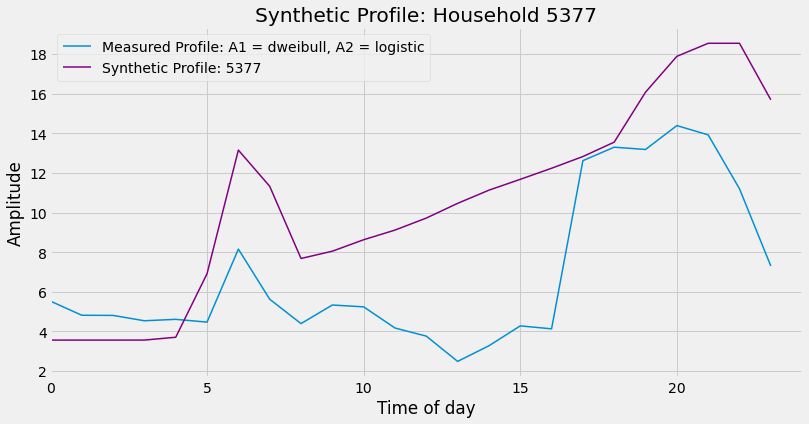

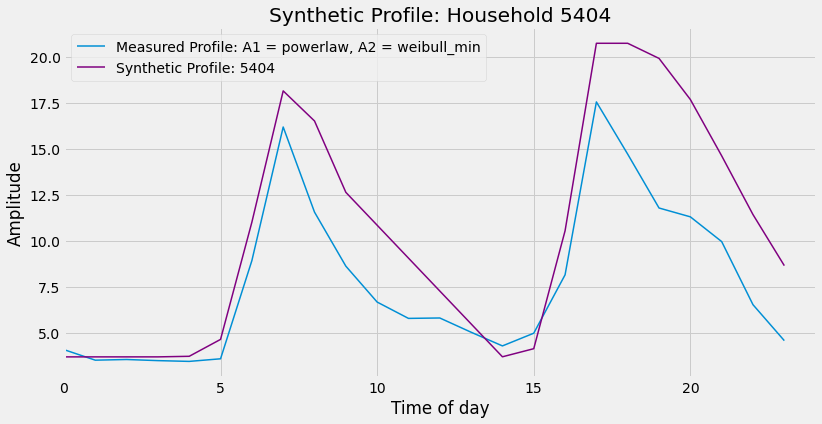

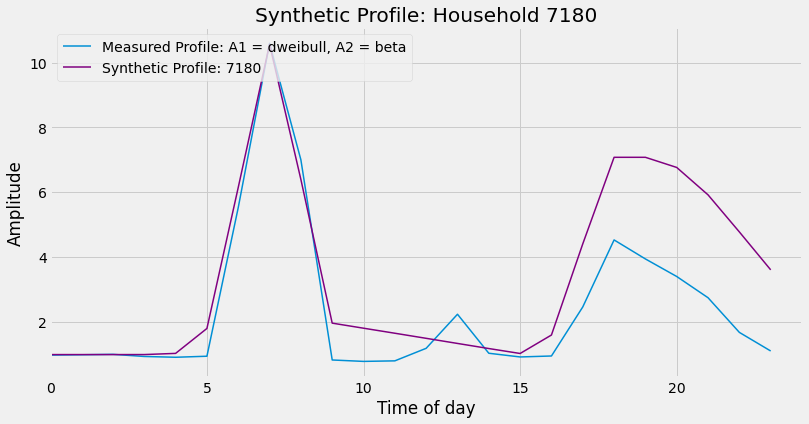

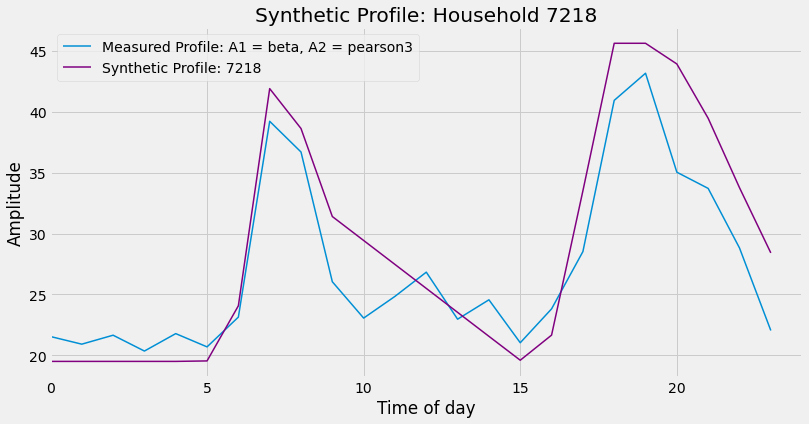

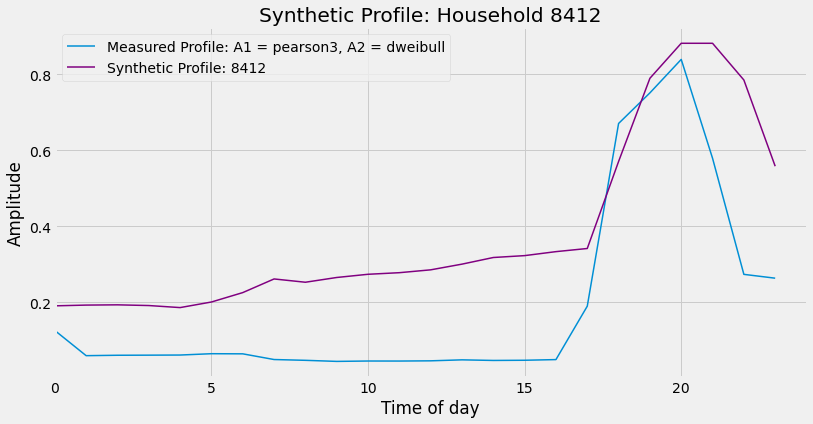

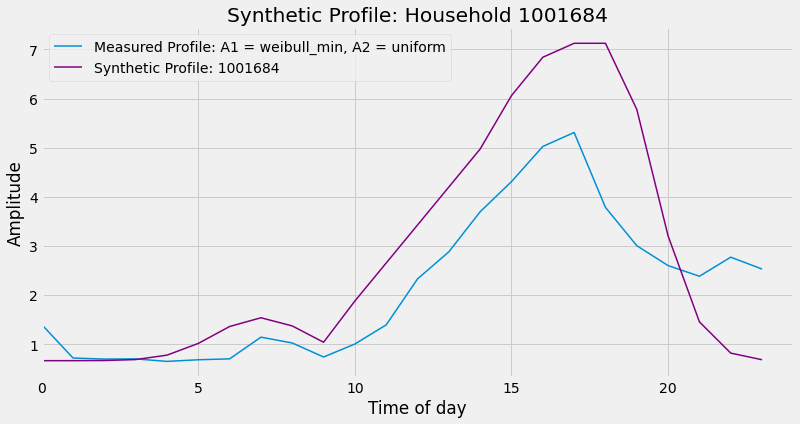

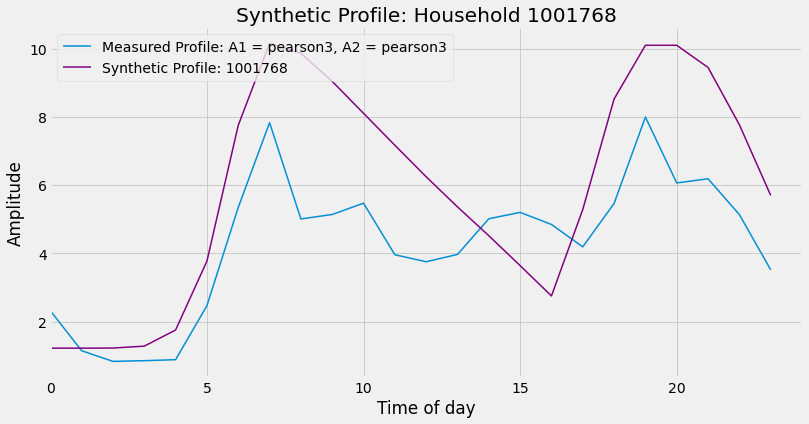

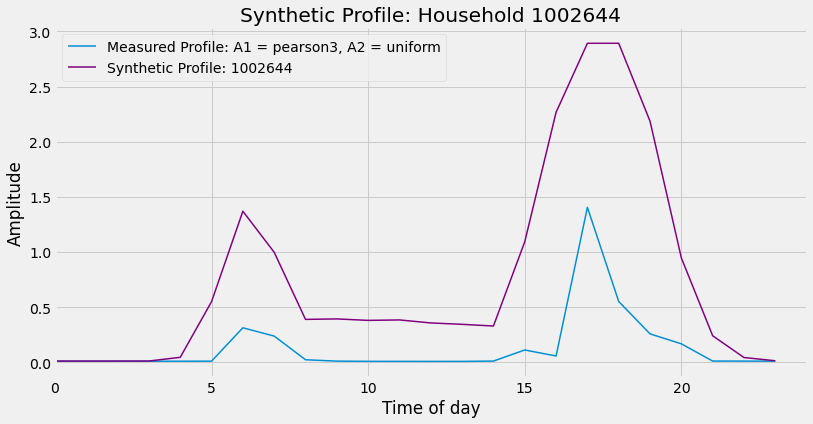

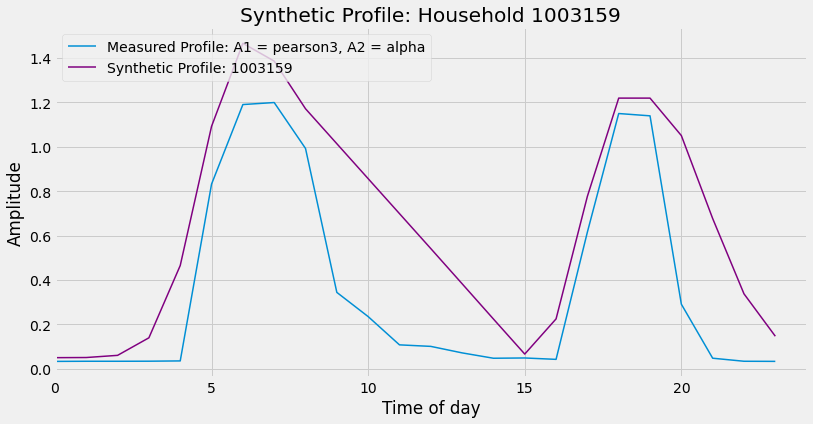

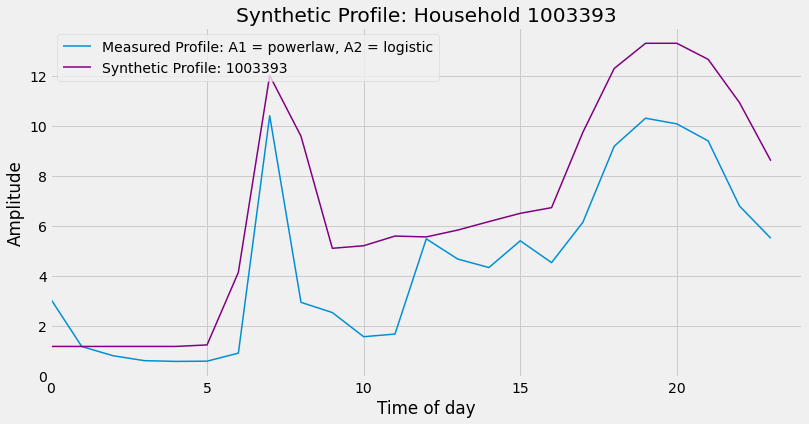

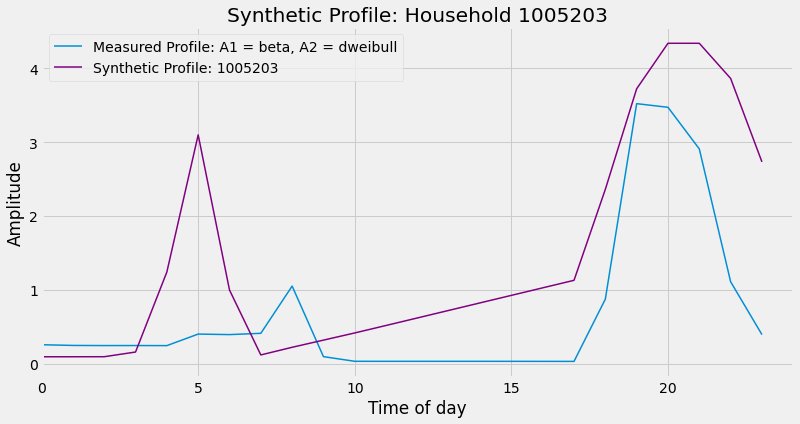

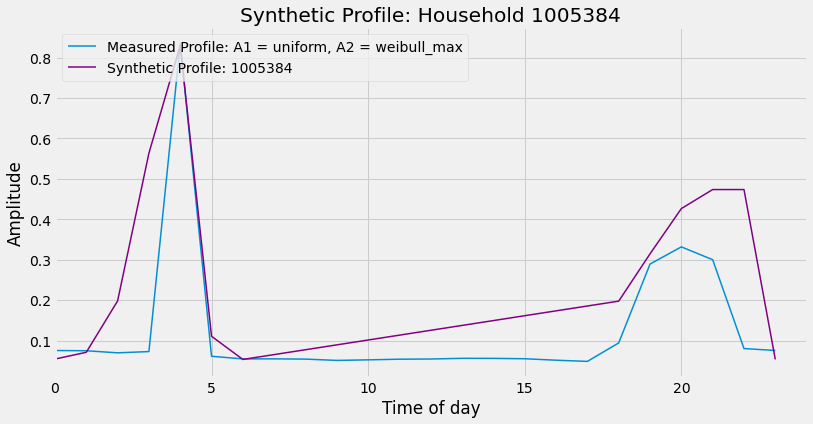

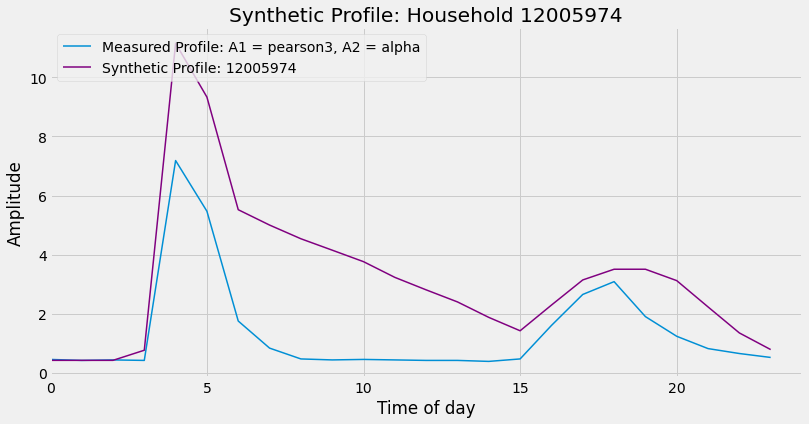

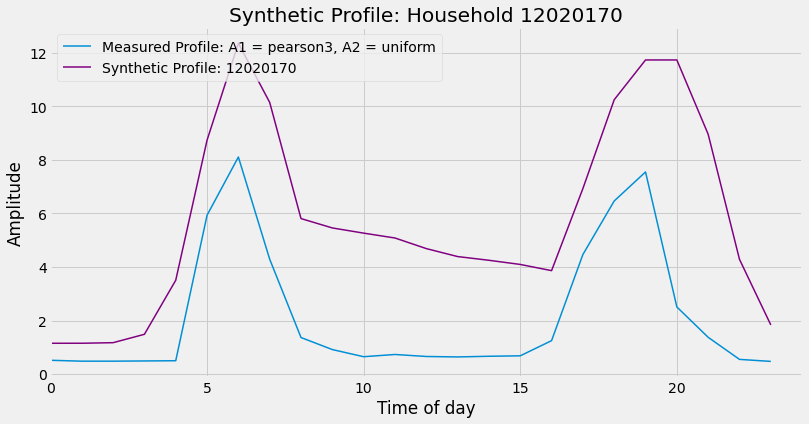

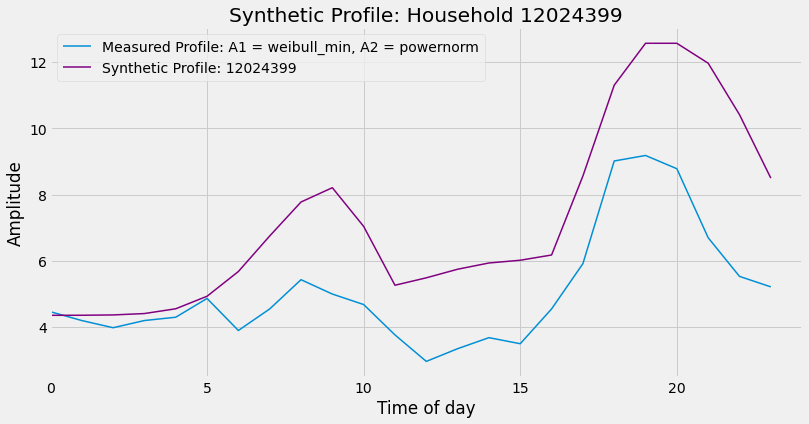

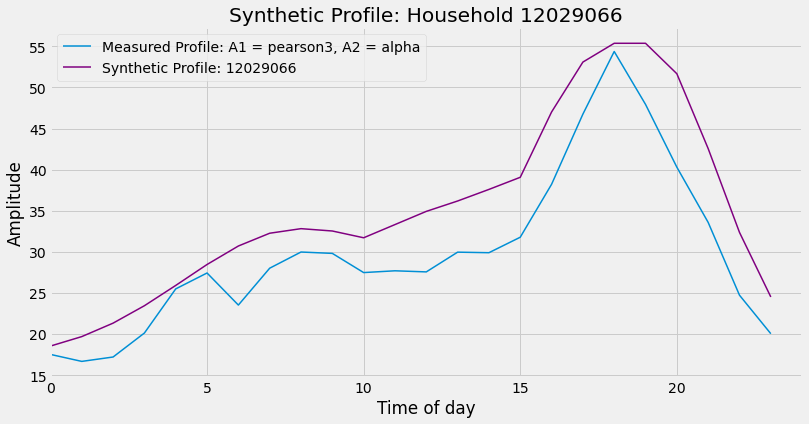

In [273]:



for houseID in synthetic_df_mean.index:

    # Measured Mean profile
    X = cleaned_df[cleaned_df["ProfileID"] == houseID]
    mean_X = X.groupby(['ProfileID']).median().values[0]

    # build the plot
    fig, ax = plt.subplots(figsize=(12,6))
    plt.style.use('fivethirtyeight')  

    # Plot the households loadprofile
    fig = plt.plot(mean_X, linewidth = 1.5, label = "Measured Profile: A1 = " + distributions_df['A1'].loc[houseID]['Distribution'] + ", A2 = " + distributions_df['A2'].loc[houseID]['Distribution'])#, linestyle = 'dashed')
    plt.title("Household "+str(houseID))
    x_all = np.arange(0,24,1)
    # Plot Gauss Fit
    ax.plot(x_all,synthetic_df_mean.loc[houseID],linewidth = 1.5, color = 'purple',label = "Synthetic Profile: " + str(houseID))# + ", RMSE = " + str('{0:.3g}'.format(RMSE)))

    plt.legend(loc = "upper left")
    # Set the labels and axis limits
    ax.set_xlim([0,24])
    ax.set_xlabel('Time of day')
    ax.set_ylabel("Amplitude")
    ax.set_title('Synthetic Profile: Household ' + str(houseID))

    # # Save the figure
    # plt.savefig('Synthetic Profile' + str(houseID) + '.png', dpi=72, bbox_inches='tight')
    plt.show()

# Check how well the syntetic profiles capture a single day

#### Check the error of the synthetic vs actual


In [194]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [195]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [196]:
cols = ['ProfileID','RMSE', 'sMAPE', 'MAPE']

errors = pd.DataFrame(columns = cols)

for houseID in synthetic_df_mean.index:

    # Measured Mean profile
    actual = cleaned_df[cleaned_df["ProfileID"] == houseID]
    actual = actual.groupby(['ProfileID']).mean().values[0]

    # predicted = synthetic_df_temp[synthetic_df_temp['ProfileID'] == houseID]
    predicted = synthetic_df_mean.loc[houseID]

    MSE = mean_squared_error(actual, predicted)
    RMSE = math.sqrt(MSE)
    MAPE = mean_absolute_percentage_error(actual, predicted)
    sMAPE = smape(actual, predicted)

    data = [[houseID, RMSE,sMAPE,MAPE]]
    temp = pd.DataFrame(data, columns = cols)
    errors = errors.append(temp)

errors.set_index(['ProfileID'], inplace = True)

In [197]:
errors

,RMSE,sMAPE,MAPE
ProfileID,,,
1225,3.059180,43.763922,60.456603
3469,0.206453,18.462799,16.318935
3712,0.407945,60.104585,119.042311
5052,0.628407,16.759057,18.969537
5377,2.540579,29.855560,36.360513
5404,2.392033,17.590756,19.486346
7180,0.565510,27.573338,26.665197
7218,17.749224,28.314139,35.664715
8412,0.353043,95.746970,189.985736


In [ ]:

actual = mean_X
predicted = synth_mean
MSE = mean_squared_error(actual, predicted)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(actual, predicted)
sMAPE = smape(actual, predicted)

In [ ]:
sMAPE

21.392736050375635

#### Check the total daily energy error of the mean vs synthetic profile

In [ ]:
Eactual = actual.sum()
Esynth = synth_mean.sum()

percentage_error = abs(Eactual - Esynth)/Eactual*100
percentage_error

18.348702138560398

## Plot the results of the fitted distribution

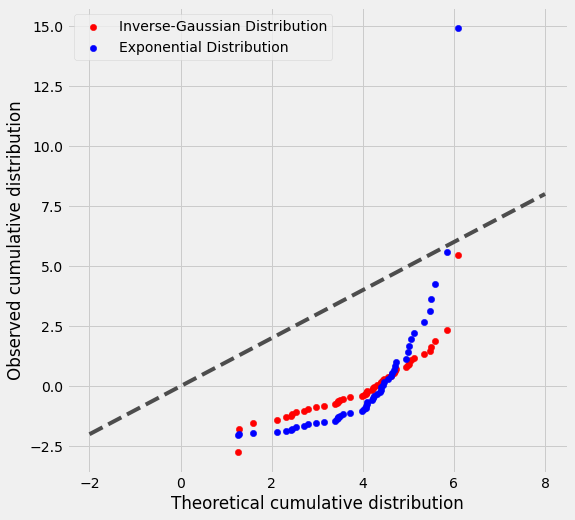

In [ ]:
data_points = expon.rvs(-2.024, 2.02402, size=2000)   # (-2.024029952926784, 2.0240299529267833)
data_points2 = invgauss.rvs(0.0291, -5.805, 199.178,size = 2000) # 0.029144801515814635, -5.80502010913426, 199.17870918874007

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='r',label = 'Inverse-Gaussian Distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='b',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()

1.0939473068569046 0.25298669830354836 0.17024613890652113


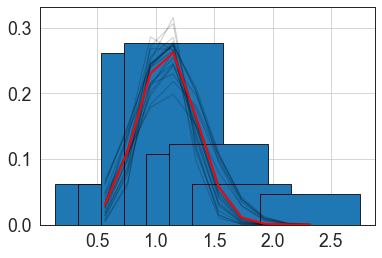

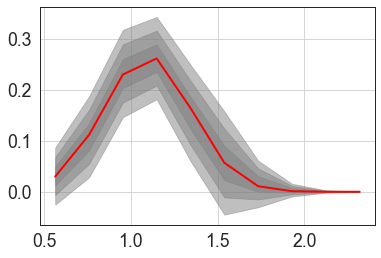

In [ ]:
from fitter import HistFit
from pylab import hist
import scipy.stats
data = dataset.loc[12004882]['A1'].values#[scipy.stats.norm.rvs(2,3.4) for x in  range(10000)]
Y, X, _ = hist(data, bins=10)
hf = HistFit(X=X, Y=Y)
hf.fit(error_rate=0.03, Nfit=20)
print(hf.mu, hf.sigma, hf.amplitude)

In [ ]:
# def extract_all_amplitudes(df,id):

#     A1, A2, mu1, mu2 = extractToPs(df, id)

#     data=[[id, A1, A2, mu1, mu2]]

#     temp_df = pd.DataFrame(data, columns=cols)
#     temp_df.set_index(['ProfileID'])
#     gauss_df = gauss_df.append(temp_df)

In [ ]:
# for id in reduced_list:
#     for row in cleaned_df.loc[id]:
#         print(row)


### Winter Weekdays

In [ ]:
# path =r'C:\Users\Jason\thesis_project\data\features\FitFeatures\Winter_Weekdays'
# list_files = []
# for root, dirs, files in os.walk(path):
# 	for file in files:
# 		list_files.append(os.path.join(root,file))

# dfs = []
# res = ''
# for name in list_files:
#     temp_df = pd.read_csv(name,header=[0, 1], index_col = 0)
#     dfs.append(temp_df)

# res = pd.concat(dfs, ignore_index=False)  # concatenate list of dataframes

# res

# Get the amplitude deviation

### Winter-weekdays

In [ ]:
# X.reset_index(inplace = True)

# df = X.copy()

# # Extract Season
# df['month'] = df.date.dt.month
# df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
# df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# # Extract Weekdays
# weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
# df_winter['day_names'] = df_winter.date.dt.day_name()
# df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
# df_winter.drop(['day_names'], axis = 1, inplace = True)
# df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
# df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
# df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

# # df_winter_weekdays.to_csv("Winter_Weekdays_Dataframe.csv")


# Extract the amplitude devition

In [ ]:
# # Get the profile IDs
# ids = res.index.values

In [ ]:
# df_winter_weekdays.reset_index(["date"],inplace = True)

In [ ]:
# df_winter_weekdays = df_winter_weekdays[df_winter_weekdays.index.isin(ids)]

In [ ]:
# df_winter_weekdays.drop(['date'],axis = 1,inplace = True)

In [ ]:
# df_winter_weekdays.reset_index(inplace = True)

In [ ]:
# df_mean = df_winter_weekdays.groupby(['ProfileID']).mean()